In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
from helper import *
from scipy.stats.mstats import gmean
#Importation of all the packages
from datetime import datetime
import math
import json
import zipfile  
import ssl
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics

#To dowload data
import requests
import io
import gzip

#To create the mapchart
import iso3166
import plotly
from iso3166 import countries
import plotly.graph_objects as go

In [79]:
pageview_df = pd.read_csv("page_views_covid_related.csv.gz")
population_df = pd.read_csv("Population_countries.csv")

In [80]:

def get_pageviews_df(raw_pageview_df: pd.DataFrame, population_df: pd.DataFrame, country_dict: dict, start: str, end: str):
    '''
    Function to get the different pageviews dataset
    
    Inputs : 

        - raw_pageview_df : raw dataset from csv
        - population_df : raw population dataset from csv
        - country_dict : countries we are interested in with language code
        - start : start date (yyyy-mm-dd)
        - end : end date (yyyy-mm-dd)
        
    Output : df_pageviews, df_pageviews_cumul, df_pageviews100k, df_pageviews_cumul100k
    '''
    #inv_country_dict = {v: k for k, v in country_dict.items()}
    pageview_df_imp_country = raw_pageview_df[["date"] + list(country_dict.values())].set_index('date')
    df_pageviews = pageview_df_imp_country.loc[pageview_df_imp_country.index < end]
    df_pageviews = df_pageviews.loc[df_pageviews.index >= start]
    df_pageviews = df_pageviews.interpolate(method ='linear', limit_direction ='forward') 
    df_pageviews = df_pageviews.fillna(0)

    df_pageviews_cumul = df_pageviews.cumsum()

    COUNTRY_OWN_LANG_POP = {"Italy" : "it", "Russian Federation": "ru", "China": "zh", "Albania": "sq", 
    "Bangladesh": "bn", "Botswana": "tn", "Cambodia": "km", "Croatia": "hr", "Greece": "el", "Sweden": "sv", "Finland": "fi", "Norway": "no",
    "Malaysia": "ms", "Israel": "he", "Lithuania": "lt", "Serbia": "sr", "Slovak Republic": "sk", "Slovenia": "sl", "Turkiye": "tr",
    "Vietnam": "vi", "Bulgaria": "bg", "Czechia": "cs", "Denmark": "da", "Georgia": "ka", "Germany": "de", 
    "Hungary": "hu", "Iceland": "is", "Japan": "ja", "Kazakhstan": "kk", "Korea, Rep.": "ko", "Kyrgyz Republic": 'ky', "Netherlands": "nl", "Poland": "pl", 
    "Romania": "ro", "Tajikistan": "tg", "Thailand": "th", "Azerbaijan": "az", "Mongolia": "mn"}

    population_df = population_df[["Country Name", "2020"]]
    population_df = population_df.set_index("Country Name")
    population_df = population_df.transpose()
    population_df = population_df[list(COUNTRY_OWN_LANG_POP.keys())]
    population_df = population_df.rename(columns= COUNTRY_OWN_LANG_POP)

    df_pageviews_cumul100k = df_pageviews_cumul/population_df.values * 100000
    df_pageviews100k = df_pageviews/population_df.values * 100000
    return df_pageviews, df_pageviews_cumul, df_pageviews100k, df_pageviews_cumul100k

In [81]:

def get_cases_deaths_df(population_df: pd.DataFrame, country_dict: dict, start: str, end: str):
    '''
    Function to get the different COVID cases and deaths dataset
    
    Inputs : 

        - population_df : raw population dataset from csv
        - country_dict : countries we are interested in with language code
        - start : start date (yyyy-mm-dd)
        - end : end date (yyyy-mm-dd)

    Output : deaths, cases, deaths_cumul, cases_cumul, deaths100k, deaths100k_cumul, cases100k, cases100k_cumul
    '''
    ssl._create_default_https_context = ssl._create_unverified_context
    death_url = "https://github.com/owid/covid-19-data/blob/master/public/data/jhu/new_deaths.csv?raw=true" # Make sure the url is the raw version of the file on GitHub
    cases_url = "https://github.com/owid/covid-19-data/blob/master/public/data/jhu/new_cases.csv?raw=true"

    # Reading the downloaded content and turning it into a pandas dataframe
    deaths = pd.read_csv(death_url,index_col=0)
    cases = pd.read_csv(cases_url,index_col=0)
    deaths= deaths.interpolate(method ='linear', limit_direction ='forward') 
    cases = cases.interpolate(method ='linear', limit_direction ='forward') 
    deaths = deaths.fillna(0)
    cases = cases.fillna(0)
    #Keep only values between start and end
    deaths = deaths[deaths.index < end]
    cases = cases[cases.index < end]
    deaths = deaths[deaths.index >= start]
    cases = cases[cases.index >= start]

    deaths = deaths.rename(columns= country_dict)[country_dict.values()]
    cases = cases.rename(columns= country_dict)[country_dict.values()]

    deaths_cumul = deaths.cumsum()
    cases_cumul = cases.cumsum()
    
    COUNTRY_OWN_LANG_POP = {"Italy" : "it", "Russian Federation": "ru", "China": "zh", "Albania": "sq", 
    "Bangladesh": "bn", "Botswana": "tn", "Cambodia": "km", "Croatia": "hr", "Greece": "el", "Sweden": "sv", "Finland": "fi", "Norway": "no",
    "Malaysia": "ms", "Israel": "he", "Lithuania": "lt", "Serbia": "sr", "Slovak Republic": "sk", "Slovenia": "sl", "Turkiye": "tr",
    "Vietnam": "vi", "Bulgaria": "bg", "Czechia": "cs", "Denmark": "da", "Georgia": "ka", "Germany": "de", 
    "Hungary": "hu", "Iceland": "is", "Japan": "ja", "Kazakhstan": "kk", "Korea, Rep.": "ko", "Kyrgyz Republic": 'ky', "Netherlands": "nl", "Poland": "pl", 
    "Romania": "ro", "Tajikistan": "tg", "Thailand": "th", "Azerbaijan": "az", "Mongolia": "mn"}

    population_df = population_df[["Country Name", "2020"]]
    population_df = population_df.set_index("Country Name")
    population_df = population_df.transpose()
    population_df = population_df[list(COUNTRY_OWN_LANG_POP.keys())]
    population_df = population_df.rename(columns= COUNTRY_OWN_LANG_POP)

    deaths100k = deaths/population_df.values * 100000
    deaths100k_cumul = deaths_cumul/population_df.values * 100000
    cases100k = cases/population_df.values * 100000
    cases100k_cumul = cases_cumul/population_df.values * 100000
    return deaths, cases, deaths_cumul, cases_cumul, deaths100k, deaths100k_cumul, cases100k, cases100k_cumul
    

In [105]:
_, _, _, df_pageviews_cumul100k = get_pageviews_df(pageview_df, population_df, get_country_dict(), '2020-01-22', '2020-11-22')
_, _, _, _, _, deaths100k_cumul, _, cases100k_cumul = get_cases_deaths_df(population_df, get_country_dict(), '2020-01-22', '2020-11-22')

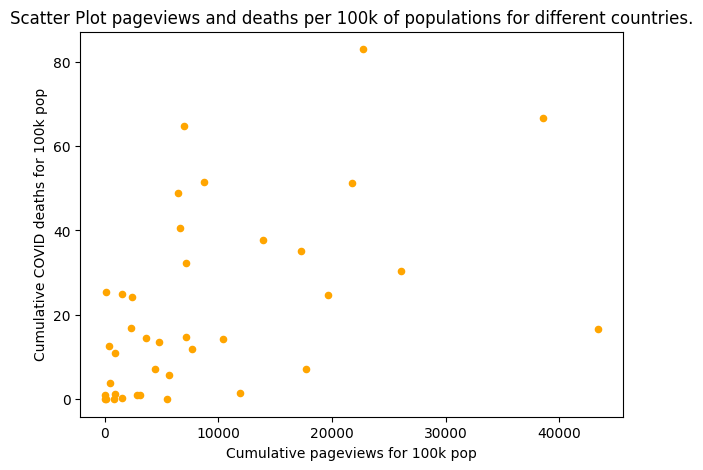

In [106]:
# create a new figure
plt.figure(figsize=(7, 5))
# use the scatter() function to plot the points,
# with red circles of size 10
plt.scatter(df_pageviews_cumul100k.max(), deaths100k_cumul.max(), color="orange", s= 20)

# add a title
plt.title("Scatter Plot pageviews and deaths per 100k of populations for different countries.")

# add x and y axis labels
plt.xlabel("Cumulative pageviews for 100k pop")
plt.ylabel("Cumulative COVID deaths for 100k pop")
#plt.legend(["Max", "Min", "Arithmetic Mean", "Median"])

# show the plot
plt.show()



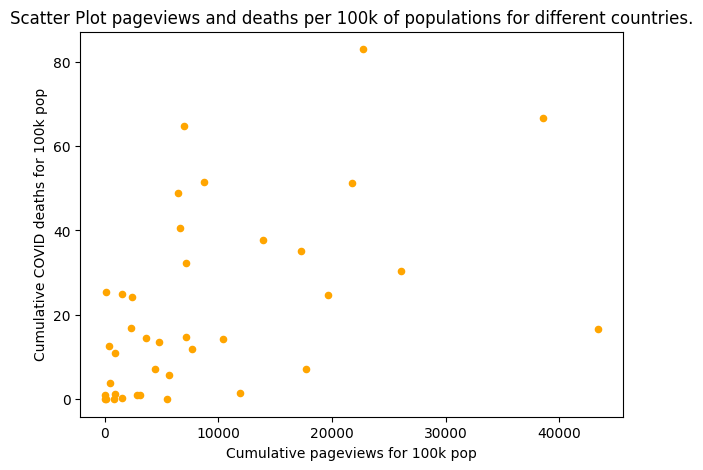

In [ ]:
# create a new figure
plt.figure(figsize=(7, 5))
# use the scatter() function to plot the points,
# with red circles of size 10
plt.scatter(df_pageviews_cumul100k.max(), deaths100k_cumul.max(), color="orange", s= 20)

# add a title
plt.title("Scatter Plot pageviews and deaths per 100k of populations for different countries.")

# add x and y axis labels
plt.xlabel("Cumulative pageviews for 100k pop")
plt.ylabel("Cumulative COVID deaths for 100k pop")
#plt.legend(["Max", "Min", "Arithmetic Mean", "Median"])

# show the plot
plt.show()



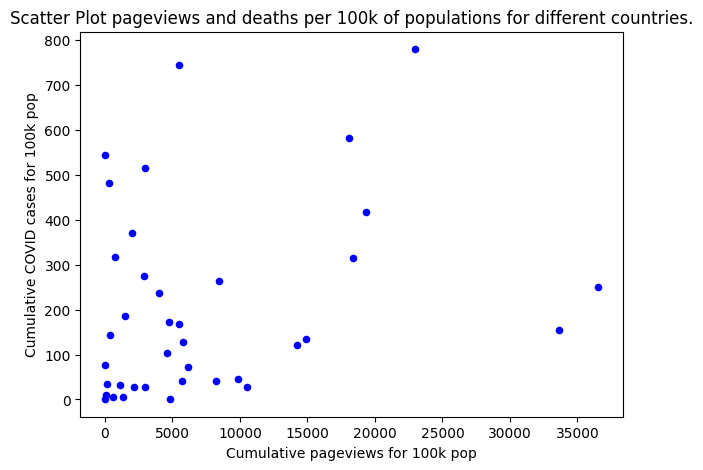

In [86]:
# create a new figure
plt.figure(figsize=(7, 5))
# use the scatter() function to plot the points,
# with red circles of size 10
plt.scatter(df_pageviews_cumul100k.max(), cases100k_cumul.max(), color="blue", s= 20)

# add a title
plt.title("Scatter Plot pageviews and deaths per 100k of populations for different countries.")

# add x and y axis labels
plt.xlabel("Cumulative pageviews for 100k pop")
plt.ylabel("Cumulative COVID cases for 100k pop")
#plt.legend(["Max", "Min", "Arithmetic Mean", "Median"])

# show the plot
plt.show()